<a href="https://colab.research.google.com/github/husainattar/Rail-Rush/blob/master/Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
import h5py
import scipy.io as io
import PIL.Image as Img
import numpy as np
import os
import glob
from matplotlib import pyplot as plt
from scipy.ndimage.filters import gaussian_filter 
from scipy import spatial
import scipy
import json
from matplotlib import cm as CM
from tqdm import tqdm
import cv2

In [0]:
#from zipfile import ZipFile

#filename='/content/drive/My Drive/Colab Notebooks/Shanghai-Dataset/ShanghaiTech_Crowd_Counting_Dataset.zip'
#destfile='/content/drive/My Drive/Colab Notebooks/Shanghai-Dataset'

#ZipFile(filename).extractall(destfile)

In [0]:
#used os module to join the paths specified
root='/content/drive'
add='My Drive/Colab Notebooks/Shanghai-Dataset'
partA_train=os.path.join(root,add,'part_A_final/train_data','images')
partA_test = os.path.join(root,add,'part_A_final/test_data','images')
partB_train = os.path.join(root,add,'part_B_final/train_data','images')
partB_test = os.path.join(root,add,'part_B_final/test_data','images')
path_sets = [partA_train,partA_test,partB_train,partB_test]

In [0]:
# List of all image paths
# glob used  for unix  style
# return recursive filepath and *.jpg means all file of that type
img_paths = []
for path in path_sets:
    #create_dir=path.replace('images','ground')
    #os.mkdir(create_dir)
    for img_path in glob.glob(os.path.join(path, '*.jpg')):
        img_paths.append(img_path)
print(len(img_paths))

1198


In [0]:
def gaussian_filter_density(gt):
    #Generates a density map using Gaussian filter transformation
    
    density = np.zeros(gt.shape, dtype=np.float32)
    
    gt_count = np.count_nonzero(gt)
    
    if gt_count == 0:
        return density

    # FInd out the K nearest neighbours using a KDTree
    
    pts = np.array(list(zip(np.nonzero(gt)[1].ravel(), np.nonzero(gt)[0].ravel())))
    leafsize = 2048
    
    # build kdtree
    tree = scipy.spatial.KDTree(pts.copy(), leafsize=leafsize)
    
    # query kdtree
    distances, locations = tree.query(pts, k=4)

        
    for i, pt in enumerate(pts):
        pt2d = np.zeros(gt.shape, dtype=np.float32)
        pt2d[pt[1],pt[0]] = 1.
        if gt_count > 1:
            sigma = (distances[i][1]+distances[i][2]+distances[i][3])*0.1
        else:
            sigma = np.average(np.array(gt.shape))/2./2. #case: 1 point
        
        #Convolve with the gaussian filter
        
        density += scipy.ndimage.filters.gaussian_filter(pt2d, sigma, mode='constant')
    
    return density

In [0]:
i = 0
for img_path in tqdm(img_paths):

    # Load sparse matrix
    mat = io.loadmat(img_path.replace('.jpg','.mat').replace('images','ground_truth').replace('IMG_','GT_IMG_'))
    
    #Read image
    img= plt.imread(img_path)
    
    # Create a zero matrix of image size
    k = np.zeros((img.shape[0],img.shape[1]))
    
    gt = mat["image_info"][0,0][0,0][0]

    #Generate hot encoded matrix of sparse matrix
    for i in range(0,len(gt)):
        if int(gt[i][1])<img.shape[0] and int(gt[i][0])<img.shape[1]:
            k[int(gt[i][1]),int(gt[i][0])]=1
    
    # generate density map
    k = gaussian_filter_density(k)
    
    # File path to save density map
    file_path = img_path.replace('.jpg','.h5').replace('images','ground')
    
    
    with h5py.File(file_path, 'w') as hf:
            hf['density'] = k


Actual Sum =  296
Sum =  293.04608


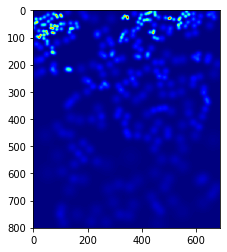

In [0]:
j=22
mat = io.loadmat(img_paths[j].replace('.jpg','.mat').replace('images','ground_truth').replace('IMG_','GT_IMG_'))
gt = mat["image_info"][0,0][0,0][0]
img=plt.imread(img_paths[j])
k = np.zeros((img.shape[0],img.shape[1]))
count=0
for i in range(0,len(gt)):
        if int(gt[i][1])<img.shape[0] and int(gt[i][0])<img.shape[1]:
            count=count+1
            k[int(gt[i][1]),int(gt[i][0])]=1

k = gaussian_filter_density(k)
plt.imshow(k,cmap=CM.jet)
print("Actual Sum = ",count)
print("Sum = " ,np.sum(k))
# density = np.zeros(gt.shape, dtype=np.float32)
    
# gt_count = np.count_nonzero(k)

# if gt_count == 0:
#     density
# pts=list(zip(np.nonzero(k)[1].ravel(),np.nonzero(k)[0].ravel()))
# leafsize=2048

# tree = scipy.spatial.KDTree(pts.copy(), leafsize=leafsize)

# distances, locations = tree.query(pts[22], k=4)

# pt2d = np.zeros(k.shape, dtype=np.float32)
# pt2d[pts[22][1],pts[22][0]] = 1.

# sigma = (distances[1]+distances[2]+distances[3])*0.1

# density = scipy.ndimage.filters.gaussian_filter(pt2d, sigma, mode='constant')

# file_path = img_paths[22].replace('.jpg','.h5').replace('images','ground')


529277
Sum =  293.04608


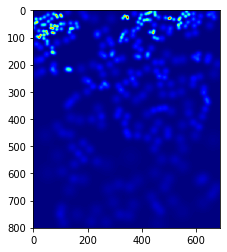

In [0]:
#Example Sample Execution
file_path = img_paths[22].replace('.jpg','.h5').replace('images','ground')
#file_path=os.path.join(root,add,'part_A_final/train_data/ground/IMG_87.h5')
gt_file = h5py.File(file_path,'r')
ground_val=np.asarray(gt_file['density'])
print(np.count_nonzero(ground_val))
plt.imshow(ground_val,cmap=CM.jet)
print("Sum = " ,np.sum(ground_val))

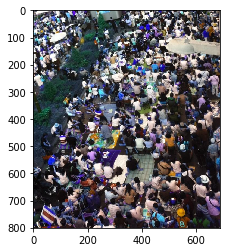

In [0]:
img = cv2.imread(file_path.replace('.h5','.jpg').replace('ground','images'))
plt.imshow(img)